In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output
from sklearn import ensemble, metrics, linear_model
import random
%matplotlib inline

In [2]:
rnd=12
random.seed(rnd)
n_ft=40 #Number of features to add
max_elts=5

In [3]:
class addNearestNeighbourLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd = random_state
        self.n = n_neighbours
        self.max_elts = max_elts
        self.verbose = verbose
        self.neighbours = []
        self.clfs = []
        
    def fit(self, train, y):
        if self.rnd != None:
            random.seed(rnd)
        if self.max_elts == None:
            self.max_elts = len(train.columns)
        list_vars = list(train.columns)
        random.shuffle(list_vars)
        
        lastscores = np.zeros(self.n) + 1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars = list_vars[self.n:]
        
        for elt in list_vars:
            indice = 0
            scores = []
            for elt2 in self.neighbours:
                if len(elt2) < self.max_elts:
                    clf = linear_model.LinearRegression(fit_intercept=False, 
                                                        normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.log_loss(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains = lastscores - scores
            if gains.max() > 0:
                temp = gains.argmax()
                lastscores[temp] = scores[temp]
                self.neighbours[temp].append(elt)

        indice = 0
        for elt in self.neighbours:
            clf = linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice = indice + 1
                    
    def transform(self, train):
        indice = 0
        for elt in self.neighbours:
            train['_'.join(pd.Series(elt).sort_values().values)] = self.clfs[indice].predict(train[elt])
            indice = indice + 1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)

In [4]:
train = pd.read_csv("data/train.csv")
target = train['target'].values
test = pd.read_csv("data/test.csv")
id_test = test['ID'].values

In [5]:
#train['v22-1']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
#test['v22-1']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
#train['v22-2']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
#test['v22-2']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
#train['v22-3']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
#test['v22-3']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
#train['v22-4']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))
#test['v22-4']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))

drop_list=['v91','v1', 'v8', 'v10', 'v15', 'v17', 'v25', 'v29', 'v34', 
           'v41', 'v46', 'v54', 'v64', 'v67', 'v97', 'v105', 'v111', 'v122']
train = train.drop(['ID','target'] + drop_list,axis=1)
test = test.drop(['ID'] + drop_list,axis=1)

refcols=list(train.columns)

In [6]:
train['v22-1']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
test['v22-1']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
train['v22-2']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
test['v22-2']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
train['v22-3']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
test['v22-3']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
train['v22-4']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))
test['v22-4']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))

In [7]:
train = train.fillna(-999)
test = test.fillna(-999)

In [7]:
for elt in refcols:
    if train[elt].dtype=='O':
        train[elt], temp = pd.factorize(train[elt])
        test[elt]=temp.get_indexer(test[elt])
    else:
        train[elt]=train[elt].round(5)
        test[elt]=test[elt].round(5)

In [6]:
ztr = (train.v22.value_counts()).index[train.v22.value_counts() > 30].values

In [7]:
train.loc[train.v22.map(lambda x: x not in ztr), 'v22'] = 0

In [8]:
means = train.groupby(by='v22').mean()
maxs = train.groupby(by='v22').max()
mins = train.groupby(by='v22').min()
medians = train.groupby(by='v22').median()

In [9]:
mens = means.loc[train.v22, :]
mens.index = train.index
mans = maxs.loc[train.v22, :]
mans.index = train.index
mns = mins.loc[train.v22, :]
mns.index = train.index
mdns = medians.loc[train.v22, :]
mdns.index = train.index

In [10]:
ntrain = pd.concat((train, mens, mans, mns, mdns), axis=1)

In [11]:
train.shape, ntrain.shape

((114321, 113), (114321, 509))

In [13]:
ntrain.columns = ['v'+str(i) for i in range(509)]

In [14]:
refcols=list(ntrain.columns)
for elt in refcols:
    if ntrain[elt].dtype=='O':
        ntrain[elt], temp = pd.factorize(ntrain[elt])
        #test[elt]=temp.get_indexer(test[elt])
    else:
        ntrain[elt]=ntrain[elt].round(5)
        #test[elt]=test[elt].round(5)

In [15]:
import xgboost as xgb

In [16]:
dtrain = xgb.DMatrix(ntrain, target)

In [17]:
params = {
    'eta': .3,
    'silent': 1,
    'nthread': 12,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': .8,
    'colsample_bytree': .8,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 0
}

In [18]:
xgb.cv(params, dtrain, num_boost_round=500, nfold=4, stratified=True, metrics='logloss', verbose_eval=True)

[0]	cv-test-logloss:0.5978327499999999+0.0006750319899826836	cv-train-logloss:0.5966130000000001+0.0006767787673974394
[1]	cv-test-logloss:0.5475265+0.0013140392878449151	cv-train-logloss:0.5450475+0.000741485502218351
[2]	cv-test-logloss:0.51830175+0.0006695160098907166	cv-train-logloss:0.5147042500000001+0.001105487533851003
[3]	cv-test-logloss:0.501724+0.0010684481737547938	cv-train-logloss:0.49688825000000003+0.0020205573952501404
[4]	cv-test-logloss:0.49201275+0.0008954876813781488	cv-train-logloss:0.4857785+0.0017408063505169006
[5]	cv-test-logloss:0.48478849999999996+0.001070837405958533	cv-train-logloss:0.4771265+0.0009040366419564985
[6]	cv-test-logloss:0.48095175+0.0010338163219353947	cv-train-logloss:0.4719545+0.0007506092525408892
[7]	cv-test-logloss:0.47789499999999996+0.001024887310878613	cv-train-logloss:0.46750800000000003+0.0005765604911889093
[8]	cv-test-logloss:0.47620225000000005+0.0010471662654516723	cv-train-logloss:0.46436849999999996+0.0004225958471163658
[9]	cv

KeyboardInterrupt: 

In [19]:
from sklearn.cross_validation import cross_val_score

In [23]:
fntrain = ntrain.fillna(-999)

In [24]:
cross_val_score(ensemble.ExtraTreesClassifier(n_estimators=750, max_features=50 ,criterion='entropy',
                                                min_samples_split=4, max_depth=35, min_samples_leaf=2, 
                                                n_jobs=-1, random_state=12),
                fntrain, target, scoring='log_loss', cv=4, n_jobs=1)

array([-0.48433754, -0.48323283, -0.48327725, -0.48193341])

In [7]:
a=addNearestNeighbourLinearFeatures(n_neighbours=n_ft, max_elts=max_elts, verbose=True, random_state=rnd)
a.fit(train, target)

train = a.transform(train)
test = a.transform(test)

0 0.564640677692 ['v95', 'v22-3']
1 0.78492204104 ['v93', 'v39', 'v55', 'v45']
2 1.0150421579 ['v103', 'v32']
3 1.2237846517 ['v112', 'v30', 'v38', 'v90', 'v100']
4 0.695421552089 ['v77', 'v18']
5 1.51026055801 ['v12', 'v52', 'v24']
6 0.912545995271 ['v131', 'v69']
7 0.590485761075 ['v50', 'v14']
8 1.27423497001 ['v71', 'v51', 'v107', 'v129', 'v85']
9 1.34909645163 ['v82', 'v89', 'v70']
10 0.953489101882 ['v128', 'v114']
11 0.597755677821 ['v102', 'v110', 'v11', 'v35', 'v121']
12 0.67363493342 ['v6', 'v49']
13 0.560716786825 ['v43', 'v53']
14 0.55909244045 ['v47', 'v22-4']
15 1.02753943928 ['v62', 'v31']
16 1.71151478424 ['v40', 'v58']
17 0.586971031973 ['v116', 'v20']
18 0.672166410312 ['v5', 'v108', 'v81']
19 0.549512531659 ['v22-1', 'v109']
20 0.74920712197 ['v61', 'v127', 'v101']
21 0.777851399127 ['v117', 'v23', 'v27', 'v126', 'v94']
22 0.933721028047 ['v92', 'v28', 'v72', 'v3']
23 0.63493438842 ['v88', 'v68']
24 0.661909492268 ['v65', 'v26']
25 0.731832815015 ['v115', 'v76', 'v33

In [ ]:
params = [{'max_features': 50, 'max_depth': 35, 'random'}]

In [9]:
preds = list()
for mf in [50, 60, 70]:
    for md in [35, 40, 45]:
        for rnd in [0, 12, 42]:
            print(rnd, md, mf, flush=True)
            clf = ensemble.ExtraTreesClassifier(n_estimators=3750, max_features=mf ,criterion='entropy',
                                                min_samples_split=4, max_depth=md, min_samples_leaf=2, 
                                                n_jobs = -1, random_state=rnd)
            clf.fit(train,target)
            pred_et = clf.predict_proba(test)[:, 1]
            preds.append(pred_et)

0 35 50
12 35 50
42 35 50
0 40 50
12 40 50
42 40 50
0 45 50
12 45 50
42 45 50
0 35 60
12 35 60
42 35 60
0 40 60
12 40 60
42 40 60
0 45 60
12 45 60
42 45 60
0 35 70
12 35 70
42 35 70
0 40 70
12 40 70
42 40 70
0 45 70
12 45 70
42 45 70


In [12]:
np.array(preds).mean(axis=0).shape

(114393,)

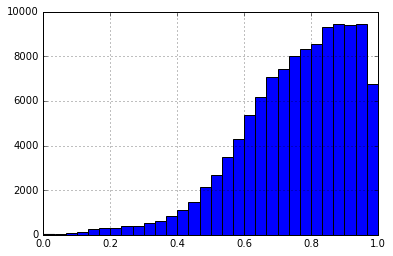

In [14]:
submission=pd.read_csv('data/sample_submission.csv')
submission.index=submission.ID
submission.PredictedProb=np.array(preds).mean(axis=0)
submission.to_csv('submission/et_ln_bag1.csv', index=False)
submission.PredictedProb.hist(bins=30)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

 # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

from sklearn import ensemble, metrics, linear_model
import random

#Some parameters to play with
rnd=12
random.seed(rnd)
n_ft=20 #Number of features to add
max_elts=3 #Maximum size of a group of linear features

class addNearestNeighbourLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd=random_state
        self.n=n_neighbours
        self.max_elts=max_elts
        self.verbose=verbose
        self.neighbours=[]
        self.clfs=[]
        
    def fit(self,train,y):
        if self.rnd!=None:
            random.seed(rnd)
        if self.max_elts==None:
            self.max_elts=len(train.columns)
        list_vars=list(train.columns)
        random.shuffle(list_vars)
        
        lastscores=np.zeros(self.n)+1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars=list_vars[self.n:]
        
        for elt in list_vars:
            indice=0
            scores=[]
            for elt2 in self.neighbours:
                if len(elt2)<self.max_elts:
                    clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.log_loss(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains=lastscores-scores
            if gains.max()>0:
                temp=gains.argmax()
                lastscores[temp]=scores[temp]
                self.neighbours[temp].append(elt)

        indice=0
        for elt in self.neighbours:
            clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice=indice+1
                    
    def transform(self, train):
        indice=0
        for elt in self.neighbours:
            train['_'.join(pd.Series(elt).sort_values().values)]=self.clfs[indice].predict(train[elt])
            indice=indice+1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)
    
    
train = pd.read_csv("../input/train.csv")
target = train['target'].values
test = pd.read_csv("../input/test.csv")
id_test = test['ID'].values

train['v22-1']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
test['v22-1']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
train['v22-2']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
test['v22-2']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
train['v22-3']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
test['v22-3']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
train['v22-4']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))
test['v22-4']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))

drop_list=['v91','v1', 'v8', 'v10', 'v15', 'v17', 'v25', 'v29', 'v34', 'v41', 'v46', 'v54', 'v64', 'v67', 'v97', 'v105', 'v111', 'v122']
train = train.drop(['ID','target'] + drop_list,axis=1).fillna(-999)
test = test.drop(['ID'] + drop_list,axis=1).fillna(-999)

refcols=list(train.columns)

for elt in refcols:
    if train[elt].dtype=='O':
        train[elt], temp = pd.factorize(train[elt])
        test[elt]=temp.get_indexer(test[elt])
    else:
        train[elt]=train[elt].round(5)
        test[elt]=test[elt].round(5)
        
a=addNearestNeighbourLinearFeatures(n_neighbours=n_ft, max_elts=max_elts, verbose=True, random_state=rnd)
a.fit(train, target)

train = a.transform(train)
test = a.transform(test)

clf = ensemble.ExtraTreesClassifier(n_estimators=750,max_features=50,criterion= 'entropy',min_samples_split= 4,
                        max_depth= 35, min_samples_leaf= 2, n_jobs = -1, random_state=rnd)

clf.fit(train,target)
pred_et=clf.predict_proba(test)

submission=pd.read_csv('../input/sample_submission.csv')
submission.index=submission.ID
submission.PredictedProb=pred_et[:,1]
submission.to_csv('./addNNLinearFt.csv', index=False)
submission.PredictedProb.hist(bins=30)